In [1]:
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

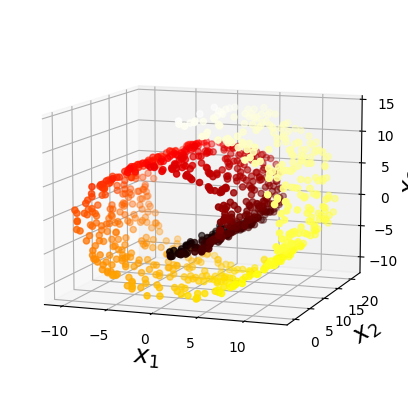

In [4]:
import matplotlib.pyplot as plt
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

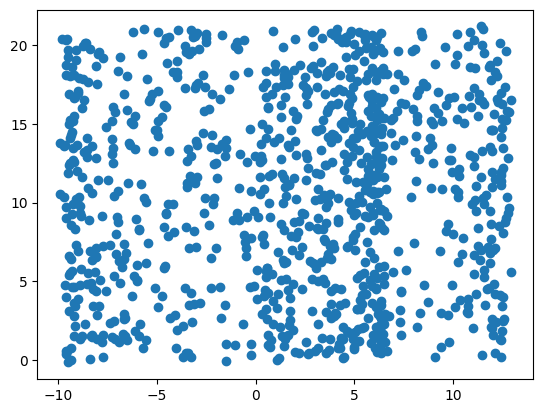

In [7]:
plt.scatter(X[:,0], X[:,1])

In [8]:
pca.components_

array([[ 0.56791312,  0.15670748,  0.80803308],
       [-0.77712377, -0.2213858 ,  0.5891239 ]])

In [9]:
pca.explained_variance_ratio_

array([0.40782396, 0.3020019 ])

In [11]:
import numpy as np
pca = PCA()
pca.fit(X)
# Computes the amount of dimensions needed to preserve 60% of the variance in the data
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.60) + 1
d

2

/home/eddie/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


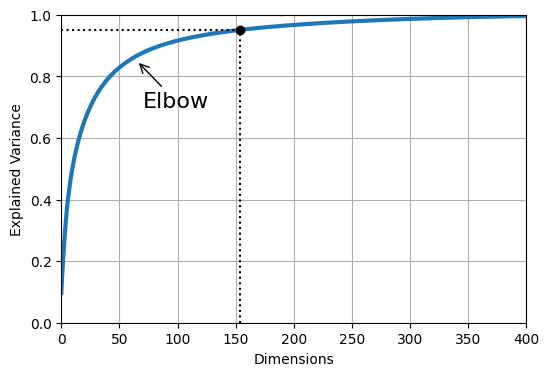

In [14]:
# You can also just specify the amount of variance you would like to preserve in the constructor
pca = PCA(n_components=0.60)
X_reduced = pca.fit_transform(X)

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)


from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
# Computes the amount of dimensions needed to preserve 60% of the variance in the data
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1


plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
# Out-of-core incremental PCA

from sklearn.decomposition import IncrementalPCA

n_batches = 100
pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    pca.partial_fit(X_batch)

X_reduced = pca.transform(X_train)

# Can use memmap instead as well
# Allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory
# np.memmap only loads the data it needs in memory, when it needs it

In [15]:
from sklearn.decomposition import KernelPCA

from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

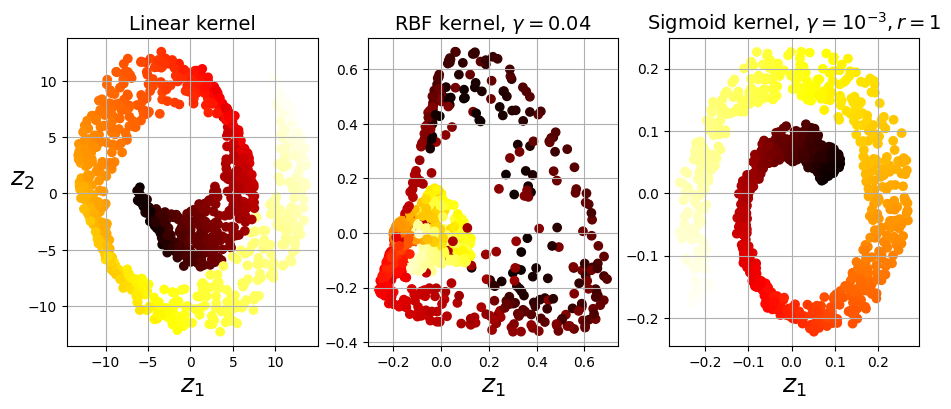

In [16]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [18]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766104

In [19]:
# We can use grid search to find the kernel and hyperparameters that minimize this reconstruction pre-image error

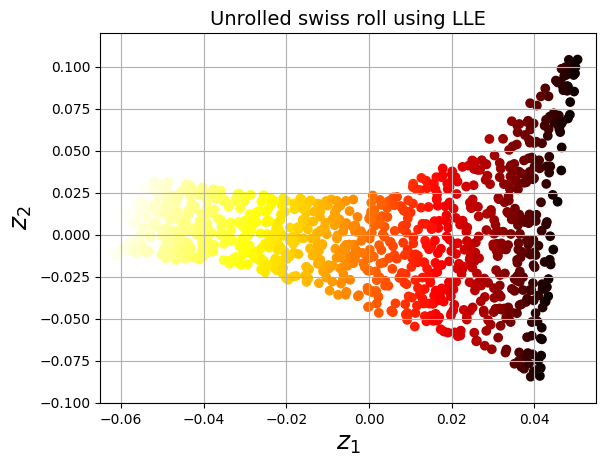

In [29]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import time

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

rf = RandomForestClassifier(n_estimators=100)

st = time.monotonic()
rf.fit(X_train, y_train)
et = time.monotonic()


acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Took {(et-st):4f} seconds with accuracy {acc}")

/home/eddie/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Took 23.656199 seconds with accuracy 0.9713


In [46]:
from sklearn.decomposition import PCA

pca_st = time.monotonic()
pca = PCA(n_components=0.95)
X = pca.fit_transform(X)
X_train_reduced = X[:60000]
X_test_reduced = X[60000:]

st = time.monotonic()
rf.fit(X_train_reduced, y_train)
et = time.monotonic()

acc = accuracy_score(y_test, rf.predict(X_test_reduced))
print(f"Took {(et-st):4f} seconds with accuracy {acc}")

Took 65.938408 seconds with accuracy 0.95


In [48]:
from sklearn.linear_model import LogisticRegression

sm = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
st = time.monotonic()
sm.fit(X_train, y_train)
et = time.monotonic()

/home/eddie/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
acc = accuracy_score(y_test, sm.predict(X_test))
print(f"Took {(et-st):4f} seconds with accuracy {acc}")

Took 12.190777 seconds with accuracy 0.9255


In [51]:
st = time.monotonic()
sm.fit(X_train_reduced, y_train)
et = time.monotonic()
acc = accuracy_score(y_test, sm.predict(X_test_reduced))
print(f"Took {(et-st):4f} seconds with accuracy {acc}")

Took 3.728985 seconds with accuracy 0.92


/home/eddie/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_reduced = tsne.fit_transform(X)

X_reduced.shape

(70000, 2)

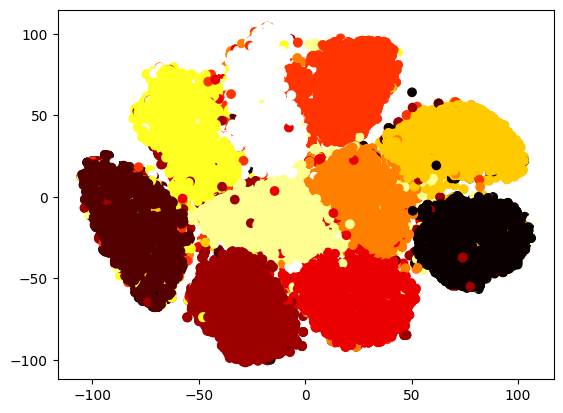

In [58]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y,cmap="hot")

In [59]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)